In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")



## DATA LOADING, CLEANING & INTEGRATION

In [2]:
# Load datasets

orders = pd.read_csv("Orders.csv", encoding="latin-1", sep=";", decimal =",")
leadtime = pd.read_csv("LeadtimeService.csv", encoding="latin-1", sep=";")
airports = pd.read_csv("airports.csv", encoding="latin-1", sep=",", decimal =",")


In [3]:
orders

,Type,Direction,DSV-CW Ref.,Goods Description,Pcs,UQ,Gwgt,UQ.1,Cwgt,UQ.2,...,Service Level,DGR,Real Origin Airport,Real Destination Airport,CTRY \nORIGIN-DESTINATION,AIRPORT ORIGIN-DESTINATION,ZONE,Tiempo (h),Request weekday,Request Delivery Day
0,ROA,Export,SBCN0269394,ENGINE 645612 + STAND,1,PCE,9800.00,KG,9800.000,KG,...,ROV,Non HAZ,BCN,MAD,ES-ES,BCN - MAD,Z1,47:19:00,mi,vi
1,ROA,Export,SBCN0266096,ENGINE P800230 + STAND SN341,2,PCE,8025.00,KG,8025.000,KG,...,ROV,Non HAZ,BCN,MAD,ES-ES,BCN - MAD,Z1,11:31:00,ju,vi
2,ROA,Export,SBCN0257348,CIVIL AIRCRAFT ENGINE,1,CRT,7200.00,KG,9318.681,KG,...,AOV,Non HAZ,BCN,LHR,ES-GB,BCN - LHR,Z3,112:10:00,ju,ma
3,ROA,Export,SBCN0257611,CIVIL AIRCRAFT ENGINE 849411,1,CRT,7200.00,KG,9773.227,KG,...,AOV,Non HAZ,BCN,LHR,ES-GB,BCN - LHR,Z3,111:42:00,ju,ma
4,ROA,Import,SBCN0271037,AC PARTS / ENGINE,2,PLT,7200.00,KG,7200.000,KG,...,AOV,Non HAZ,MAD,BCN,ES-ES,MAD - BCN,Z1,109:56:00,mi,lu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3690,DSx,Import,SBCN0267373,AC PARTS / ROUTINE,1,PKG,0.10,KG,0.330,KG,...,ROV,Non HAZ,TLS,BCN,FR-ES,TLS - BCN,Z2,50:38:00,ma,ju
3691,AIR,Export,SBCN0269726,CIVIL AIRCRAFT PARTS,1,BOX,0.10,KG,0.330,KG,...,AOV,Non HAZ,BCN,BEG,ES-RS,BCN - BEG,Z3,37:22:00,lu,mi
3692,AIR,Import,SLHR0368471,CIVIL AIRCRAFT PARTS - FLAP MOUNT,1,BOX,0.10,KG,2.000,KG,...,AOV,Non HAZ,LHR,BCN,GB-ES,LHR - BCN,Z3,21:58:00,lu,ma
3693,DSx,Import,SBCN0274152,AC PARTS - ROUTINE,1,PKG,0.03,KG,3.000,KG,...,ROV,Non HAZ,PRG,BCN,CZ-ES,PRG - BCN,Z2,48:30:00,mi,vi


In [4]:
# Select relevant columns for analysis from orders dataset

cols_keep = [
    "Type",
    "Direction",
    "DSV-CW Ref.",
    "Goods Description",
    "Pcs",
    "Gwgt",
    "Cwgt",
    "NOTIFICATION date & Time",
    "ACTUAL Delivery & Time",
    "Service Level",
    "DGR",
    "Real Origin Airport",
    "Real Destination Airport",
    "ZONE",
    "AIRPORT ORIGIN-DESTINATION"
]

df_analysis = orders[cols_keep]

In [5]:
df_analysis["Service Level"].value_counts()

Service Level
ROV                                    2099
AOV                                    1233
CRV                                     330
ERROR en Service Level (columna AK)      33
Name: count, dtype: int64

In [6]:
#drop rows with service level: "ERROR en Service Level (columna AK)"

df_analysis = df_analysis[df_analysis["Service Level"] != "ERROR en Service Level (columna AK)"]

In [7]:
df_analysis["Service Level"].value_counts()

Service Level
ROV    2099
AOV    1233
CRV     330
Name: count, dtype: int64

In [8]:
# Service Level mapping used in the analysis
service_level_mapping = {
    "ROV": "Normal",
    "CRV": "Urgent",
    "AOV": "Critical"
}

df_analysis["Service Type"] = (
    df_analysis["Service Level"]
    .map(service_level_mapping)
)

df_analysis[["Service Level", "Service Type"]].drop_duplicates()

,Service Level,Service Type
0,ROV,Normal
2,AOV,Critical
19,CRV,Urgent


In [9]:
df_analysis["ZONE"].value_counts()

ZONE
Z2    2080
Z4     719
Z3     662
Z5     139
Z6      41
Z1      21
Name: count, dtype: int64

In [10]:
leadtime

,Zone,Zone description,SLA,Leadtime
0,Z6,Others,ROV,72
1,Z6,Others,CRV,48
2,Z6,Others,AOV,24
3,Z5,LATAM,ROV,72
4,Z5,LATAM,CRV,48
5,Z5,LATAM,AOV,24
6,Z4,N.A.,ROV,72
7,Z4,N.A.,CRV,48
8,Z4,N.A.,AOV,24
9,Z3,EUR,ROV,72


In [11]:
#Drop spaces in column names
df_analysis.columns = df_analysis.columns.str.strip()
leadtime.columns = leadtime.columns.str.strip()

# Clean string columns to ensure proper merging
df_analysis["ZONE"] = df_analysis["ZONE"].astype(str).str.strip()
df_analysis["Service Level"] = df_analysis["Service Level"].astype(str).str.strip()

leadtime["Zone"] = leadtime["Zone"].astype(str).str.strip()
leadtime["SLA"] = leadtime["SLA"].astype(str).str.strip()

# Merge lead time information into the main dataframe

df_analysis = df_analysis.merge(
    leadtime[["Zone", "SLA", "Leadtime"]],
    how="left",
    left_on=["ZONE", "Service Level"],
    right_on=["Zone", "SLA"]
)

# Limpiar columnas auxiliares del join
df_analysis.drop(columns=["Zone", "SLA"], inplace=True)


In [12]:
df_analysis

,Type,Direction,DSV-CW Ref.,Goods Description,Pcs,Gwgt,Cwgt,NOTIFICATION date & Time,ACTUAL Delivery & Time,Service Level,DGR,Real Origin Airport,Real Destination Airport,ZONE,AIRPORT ORIGIN-DESTINATION,Service Type,Leadtime
0,ROA,Export,SBCN0269394,ENGINE 645612 + STAND,1,9800.00,9800.000,07/05/2025 15:41,09/05/2025 15:00,ROV,Non HAZ,BCN,MAD,Z1,BCN - MAD,Normal,24
1,ROA,Export,SBCN0266096,ENGINE P800230 + STAND SN341,2,8025.00,8025.000,03/04/2025 12:29,04/04/2025 0:00,ROV,Non HAZ,BCN,MAD,Z1,BCN - MAD,Normal,24
2,ROA,Export,SBCN0257348,CIVIL AIRCRAFT ENGINE,1,7200.00,9318.681,16/01/2025 18:30,21/01/2025 10:40,AOV,Non HAZ,BCN,LHR,Z3,BCN - LHR,Critical,24
3,ROA,Export,SBCN0257611,CIVIL AIRCRAFT ENGINE 849411,1,7200.00,9773.227,16/01/2025 16:18,21/01/2025 8:00,AOV,Non HAZ,BCN,LHR,Z3,BCN - LHR,Critical,24
4,ROA,Import,SBCN0271037,AC PARTS / ENGINE,2,7200.00,7200.000,21/05/2025 11:00,26/05/2025 0:56,AOV,Non HAZ,MAD,BCN,Z1,MAD - BCN,Critical,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3657,DSx,Import,SBCN0267373,AC PARTS / ROUTINE,1,0.10,0.330,15/04/2025 11:00,17/04/2025 13:38,ROV,Non HAZ,TLS,BCN,Z2,TLS - BCN,Normal,36
3658,AIR,Export,SBCN0269726,CIVIL AIRCRAFT PARTS,1,0.10,0.330,12/05/2025 10:38,14/05/2025 0:00,AOV,Non HAZ,BCN,BEG,Z3,BCN - BEG,Critical,24
3659,AIR,Import,SLHR0368471,CIVIL AIRCRAFT PARTS - FLAP MOUNT,1,0.10,2.000,19/05/2025 19:32,20/05/2025 17:30,AOV,Non HAZ,LHR,BCN,Z3,LHR - BCN,Critical,24
3660,DSx,Import,SBCN0274152,AC PARTS - ROUTINE,1,0.03,3.000,18/06/2025 11:00,20/06/2025 11:30,ROV,Non HAZ,PRG,BCN,Z2,PRG - BCN,Normal,36


In [13]:
airports

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,icao_code,iata_code,gps_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total RF Heliport,40.070985,-74.933689,11.0,NaN,US,US-PA,Bensalem,no,NaN,NaN,K00A,00A,https://www.penndot.pa.gov/TravelInPA/airports...,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,NaN,NaN,00AA,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,NaN,NaN,00AK,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.86479949951172,-86.77030181884766,820.0,NaN,US,US-AL,Harvest,no,NaN,NaN,00AL,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NaN,US,US-AK,King Salmon,no,NaN,NaN,00AN,00AN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84485,32753,ZYYY,medium_airport,Shenyang Dongta Airport,41.784354,123.496308,157.0,AS,CN,CN-21,"Dadong, Shenyang",no,ZYYY,NaN,ZYYY,NaN,NaN,NaN,"ä¸å¡æºåº, SHE"
84486,46378,ZZ-0001,heliport,Sealand Helipad,51.894444,1.4825,40.0,EU,GB,GB-ENG,Sealand,no,NaN,NaN,NaN,NaN,http://www.sealandgov.org/,https://en.wikipedia.org/wiki/Principality_of_...,Roughs Tower Helipad
84487,307326,ZZ-0002,small_airport,Glorioso Islands Airstrip,-11.584277777799999,47.296388888900005,11.0,AF,TF,TF-U-A,Grande Glorieuse,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84488,346788,ZZ-0003,small_airport,Fainting Goat Airport,32.110587,-97.356312,690.0,NaN,US,US-TX,Blum,no,NaN,NaN,87TX,87TX,NaN,NaN,NaN


In [14]:
#Drop spaces in column names
airports.columns = airports.columns.str.strip()

# Clean string columns to ensure proper merging
df_analysis["Real Origin Airport"] = df_analysis["Real Origin Airport"].astype(str).str.strip()
df_analysis["Real Destination Airport"] = df_analysis["Real Destination Airport"].astype(str).str.strip()

airports["iata_code"] = airports["iata_code"].astype(str).str.strip()

# Merge information into the main dataframe for ORIGIN airport
df_analysis = df_analysis.merge(
    airports[["iata_code", "iso_country"]],
    how="left",
    left_on="Real Origin Airport",
    right_on="iata_code"
)

# Rename columns to avoid confusion
df_analysis.rename(
    columns={
        "iata_code": "iata_code_origin",
        "iso_country": "iso_country_origin"
    },
    inplace=True
)

# Merge information into the main dataframe for DESTINATION airport
df_analysis = df_analysis.merge(
    airports[["iata_code", "iso_country"]],
    how="left",
    left_on="Real Destination Airport",
    right_on="iata_code"
)

# Rename columns to avoid confusion
df_analysis.rename(
    columns={
        "iata_code": "iata_code_destination",
        "iso_country": "iso_country_destination"
    },
    inplace=True
)


In [15]:
# Final dataframe for analysis
df_analysis = df_analysis.drop(columns=["Real Origin Airport", "Real Destination Airport"])
df_analysis

,Type,Direction,DSV-CW Ref.,Goods Description,Pcs,Gwgt,Cwgt,NOTIFICATION date & Time,ACTUAL Delivery & Time,Service Level,DGR,ZONE,AIRPORT ORIGIN-DESTINATION,Service Type,Leadtime,iata_code_origin,iso_country_origin,iata_code_destination,iso_country_destination
0,ROA,Export,SBCN0269394,ENGINE 645612 + STAND,1,9800.00,9800.000,07/05/2025 15:41,09/05/2025 15:00,ROV,Non HAZ,Z1,BCN - MAD,Normal,24,BCN,ES,MAD,ES
1,ROA,Export,SBCN0266096,ENGINE P800230 + STAND SN341,2,8025.00,8025.000,03/04/2025 12:29,04/04/2025 0:00,ROV,Non HAZ,Z1,BCN - MAD,Normal,24,BCN,ES,MAD,ES
2,ROA,Export,SBCN0257348,CIVIL AIRCRAFT ENGINE,1,7200.00,9318.681,16/01/2025 18:30,21/01/2025 10:40,AOV,Non HAZ,Z3,BCN - LHR,Critical,24,BCN,ES,LHR,GB
3,ROA,Export,SBCN0257611,CIVIL AIRCRAFT ENGINE 849411,1,7200.00,9773.227,16/01/2025 16:18,21/01/2025 8:00,AOV,Non HAZ,Z3,BCN - LHR,Critical,24,BCN,ES,LHR,GB
4,ROA,Import,SBCN0271037,AC PARTS / ENGINE,2,7200.00,7200.000,21/05/2025 11:00,26/05/2025 0:56,AOV,Non HAZ,Z1,MAD - BCN,Critical,4,MAD,ES,BCN,ES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3657,DSx,Import,SBCN0267373,AC PARTS / ROUTINE,1,0.10,0.330,15/04/2025 11:00,17/04/2025 13:38,ROV,Non HAZ,Z2,TLS - BCN,Normal,36,TLS,FR,BCN,ES
3658,AIR,Export,SBCN0269726,CIVIL AIRCRAFT PARTS,1,0.10,0.330,12/05/2025 10:38,14/05/2025 0:00,AOV,Non HAZ,Z3,BCN - BEG,Critical,24,BCN,ES,BEG,RS
3659,AIR,Import,SLHR0368471,CIVIL AIRCRAFT PARTS - FLAP MOUNT,1,0.10,2.000,19/05/2025 19:32,20/05/2025 17:30,AOV,Non HAZ,Z3,LHR - BCN,Critical,24,LHR,GB,BCN,ES
3660,DSx,Import,SBCN0274152,AC PARTS - ROUTINE,1,0.03,3.000,18/06/2025 11:00,20/06/2025 11:30,ROV,Non HAZ,Z2,PRG - BCN,Normal,36,PRG,CZ,BCN,ES


## TARGET ENGINEERING (leadtime_real)

In [16]:
#Convert date columns to datetime format

notification_col = "NOTIFICATION date & Time"
delivery_col = "ACTUAL Delivery & Time"

df_analysis[notification_col] = pd.to_datetime(
    df_analysis[notification_col],
    errors="coerce",
    dayfirst=True
)

df_analysis[delivery_col] = pd.to_datetime(
    df_analysis[delivery_col],
    errors="coerce",
    dayfirst=True
)

print("\nMissing timestamps after datetime conversion:")
display(df_analysis[[notification_col, delivery_col]].isna().sum())


Missing timestamps after datetime conversion:


NOTIFICATION date & Time    0
ACTUAL Delivery & Time      1
dtype: int64

In [17]:
#Drop rows with missing timestamps
df_analysis = df_analysis.dropna(subset=[notification_col, delivery_col])

df_analysis

,Type,Direction,DSV-CW Ref.,Goods Description,Pcs,Gwgt,Cwgt,NOTIFICATION date & Time,ACTUAL Delivery & Time,Service Level,DGR,ZONE,AIRPORT ORIGIN-DESTINATION,Service Type,Leadtime,iata_code_origin,iso_country_origin,iata_code_destination,iso_country_destination
0,ROA,Export,SBCN0269394,ENGINE 645612 + STAND,1,9800.00,9800.000,2025-05-07 15:41:00,2025-05-09 15:00:00,ROV,Non HAZ,Z1,BCN - MAD,Normal,24,BCN,ES,MAD,ES
1,ROA,Export,SBCN0266096,ENGINE P800230 + STAND SN341,2,8025.00,8025.000,2025-04-03 12:29:00,2025-04-04 00:00:00,ROV,Non HAZ,Z1,BCN - MAD,Normal,24,BCN,ES,MAD,ES
2,ROA,Export,SBCN0257348,CIVIL AIRCRAFT ENGINE,1,7200.00,9318.681,2025-01-16 18:30:00,2025-01-21 10:40:00,AOV,Non HAZ,Z3,BCN - LHR,Critical,24,BCN,ES,LHR,GB
3,ROA,Export,SBCN0257611,CIVIL AIRCRAFT ENGINE 849411,1,7200.00,9773.227,2025-01-16 16:18:00,2025-01-21 08:00:00,AOV,Non HAZ,Z3,BCN - LHR,Critical,24,BCN,ES,LHR,GB
4,ROA,Import,SBCN0271037,AC PARTS / ENGINE,2,7200.00,7200.000,2025-05-21 11:00:00,2025-05-26 00:56:00,AOV,Non HAZ,Z1,MAD - BCN,Critical,4,MAD,ES,BCN,ES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3657,DSx,Import,SBCN0267373,AC PARTS / ROUTINE,1,0.10,0.330,2025-04-15 11:00:00,2025-04-17 13:38:00,ROV,Non HAZ,Z2,TLS - BCN,Normal,36,TLS,FR,BCN,ES
3658,AIR,Export,SBCN0269726,CIVIL AIRCRAFT PARTS,1,0.10,0.330,2025-05-12 10:38:00,2025-05-14 00:00:00,AOV,Non HAZ,Z3,BCN - BEG,Critical,24,BCN,ES,BEG,RS
3659,AIR,Import,SLHR0368471,CIVIL AIRCRAFT PARTS - FLAP MOUNT,1,0.10,2.000,2025-05-19 19:32:00,2025-05-20 17:30:00,AOV,Non HAZ,Z3,LHR - BCN,Critical,24,LHR,GB,BCN,ES
3660,DSx,Import,SBCN0274152,AC PARTS - ROUTINE,1,0.03,3.000,2025-06-18 11:00:00,2025-06-20 11:30:00,ROV,Non HAZ,Z2,PRG - BCN,Normal,36,PRG,CZ,BCN,ES


In [18]:
#Creating leadtime real in hours

df_analysis["leadtime_real_hours"] = (
    (df_analysis[delivery_col] - df_analysis[notification_col])
    .dt.total_seconds() / 3600
)

df_analysis[["leadtime_real_hours", notification_col, delivery_col]]


,leadtime_real_hours,NOTIFICATION date & Time,ACTUAL Delivery & Time
0,47.316667,2025-05-07 15:41:00,2025-05-09 15:00:00
1,11.516667,2025-04-03 12:29:00,2025-04-04 00:00:00
2,112.166667,2025-01-16 18:30:00,2025-01-21 10:40:00
3,111.700000,2025-01-16 16:18:00,2025-01-21 08:00:00
4,109.933333,2025-05-21 11:00:00,2025-05-26 00:56:00
...,...,...,...
3657,50.633333,2025-04-15 11:00:00,2025-04-17 13:38:00
3658,37.366667,2025-05-12 10:38:00,2025-05-14 00:00:00
3659,21.966667,2025-05-19 19:32:00,2025-05-20 17:30:00
3660,48.500000,2025-06-18 11:00:00,2025-06-20 11:30:00


In [19]:
# Negative lead times check because of data errors
print("Negatives:", (df_analysis["leadtime_real_hours"] < 0).sum())


Negatives: 27


In [20]:
# Dealing with negative and 0 lead times

negatives_df = df_analysis[df_analysis["leadtime_real_hours"] <= 0]

print(f"Negative lead times: {len(negatives_df)}")

display(
    negatives_df[
        [
            "NOTIFICATION date & Time",
            "ACTUAL Delivery & Time",
            "leadtime_real_hours",
            "ZONE",
            "Service Level",
            "Service Type"
        ]
    ].sort_values("leadtime_real_hours")
)

Negative lead times: 31


,NOTIFICATION date & Time,ACTUAL Delivery & Time,leadtime_real_hours,ZONE,Service Level,Service Type
1605,2025-05-03 12:30:00,2022-06-05 14:43:00,-25509.783333,Z2,AOV,Critical
1748,2025-01-28 09:13:00,2024-01-29 09:15:00,-8759.966667,Z2,CRV,Urgent
620,2025-01-06 15:55:00,2024-01-07 18:22:00,-8757.550000,Z2,AOV,Critical
3219,2025-01-06 14:00:00,2024-01-07 18:22:00,-8755.633333,Z2,AOV,Critical
3098,2025-01-05 09:01:00,2024-01-06 20:35:00,-8748.433333,Z4,AOV,Critical
7,2025-01-30 08:03:00,2024-02-01 07:50:00,-8736.216667,Z3,AOV,Critical
3101,2025-04-04 09:40:00,2024-04-08 16:00:00,-8657.666667,Z2,ROV,Normal
280,2025-09-06 10:00:00,2025-06-12 16:00:00,-2058.000000,Z2,ROV,Normal
2017,2025-01-29 18:24:00,2024-12-30 11:16:00,-727.133333,Z2,ROV,Normal
2317,2025-06-19 08:19:00,2025-06-18 15:00:00,-17.316667,Z2,CRV,Urgent


In [21]:
#Flagging invalid lead times

df_analysis["invalid_leadtime_flag"] = (df_analysis["leadtime_real_hours"] <= 0).astype(int)

df_analysis["invalid_leadtime_flag"].value_counts()

invalid_leadtime_flag
0    3630
1      31
Name: count, dtype: int64

In [22]:
df_analysis = df_analysis[df_analysis["leadtime_real_hours"] > 0].copy()

#Statistics summary
print(df_analysis["leadtime_real_hours"].describe())


count    3630.000000
mean       83.871933
std        73.270683
min         0.116667
25%        27.216667
50%        65.616667
75%       119.437500
max       670.783333
Name: leadtime_real_hours, dtype: float64


In [23]:
#Creating a target with 99th percentile lead time for avoid outliers

leadtime_99th_percentile = df_analysis["leadtime_real_hours"].quantile(0.99)

df_analysis["leadtime_ml_hours"] = df_analysis["leadtime_real_hours"].clip(upper=leadtime_99th_percentile)

#Statistics summary
print(df_analysis["leadtime_ml_hours"].describe())

count    3630.000000
mean       83.088086
std        69.492946
min         0.116667
25%        27.216667
50%        65.616667
75%       119.437500
max       337.094667
Name: leadtime_ml_hours, dtype: float64


In [24]:
# leadtime_real_hours: real operational lead time (EDA)
# leadtime_ml_hours: capped target used for ML training with 99th percentile

In [25]:
#Calculating on_time comparing leadtime_real_hours with SLA
df_analysis["on_time"] = (df_analysis["leadtime_real_hours"] <= df_analysis["Leadtime"]).astype(int)

In [26]:
df_analysis

,Type,Direction,DSV-CW Ref.,Goods Description,Pcs,Gwgt,Cwgt,NOTIFICATION date & Time,ACTUAL Delivery & Time,Service Level,...,Service Type,Leadtime,iata_code_origin,iso_country_origin,iata_code_destination,iso_country_destination,leadtime_real_hours,invalid_leadtime_flag,leadtime_ml_hours,on_time
0,ROA,Export,SBCN0269394,ENGINE 645612 + STAND,1,9800.00,9800.000,2025-05-07 15:41:00,2025-05-09 15:00:00,ROV,...,Normal,24,BCN,ES,MAD,ES,47.316667,0,47.316667,0
1,ROA,Export,SBCN0266096,ENGINE P800230 + STAND SN341,2,8025.00,8025.000,2025-04-03 12:29:00,2025-04-04 00:00:00,ROV,...,Normal,24,BCN,ES,MAD,ES,11.516667,0,11.516667,1
2,ROA,Export,SBCN0257348,CIVIL AIRCRAFT ENGINE,1,7200.00,9318.681,2025-01-16 18:30:00,2025-01-21 10:40:00,AOV,...,Critical,24,BCN,ES,LHR,GB,112.166667,0,112.166667,0
3,ROA,Export,SBCN0257611,CIVIL AIRCRAFT ENGINE 849411,1,7200.00,9773.227,2025-01-16 16:18:00,2025-01-21 08:00:00,AOV,...,Critical,24,BCN,ES,LHR,GB,111.700000,0,111.700000,0
4,ROA,Import,SBCN0271037,AC PARTS / ENGINE,2,7200.00,7200.000,2025-05-21 11:00:00,2025-05-26 00:56:00,AOV,...,Critical,4,MAD,ES,BCN,ES,109.933333,0,109.933333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3657,DSx,Import,SBCN0267373,AC PARTS / ROUTINE,1,0.10,0.330,2025-04-15 11:00:00,2025-04-17 13:38:00,ROV,...,Normal,36,TLS,FR,BCN,ES,50.633333,0,50.633333,0
3658,AIR,Export,SBCN0269726,CIVIL AIRCRAFT PARTS,1,0.10,0.330,2025-05-12 10:38:00,2025-05-14 00:00:00,AOV,...,Critical,24,BCN,ES,BEG,RS,37.366667,0,37.366667,0
3659,AIR,Import,SLHR0368471,CIVIL AIRCRAFT PARTS - FLAP MOUNT,1,0.10,2.000,2025-05-19 19:32:00,2025-05-20 17:30:00,AOV,...,Critical,24,LHR,GB,BCN,ES,21.966667,0,21.966667,1
3660,DSx,Import,SBCN0274152,AC PARTS - ROUTINE,1,0.03,3.000,2025-06-18 11:00:00,2025-06-20 11:30:00,ROV,...,Normal,36,PRG,CZ,BCN,ES,48.500000,0,48.500000,0


## Exploratory Data Analysis


In [27]:
# SLA RECOMMENDATION (Business logic)

# Goal: downgrade ONLY as needed based on real leadtime:
# - If real <= SLA(Critical)  -> recommend Critical
# - elif real <= SLA(Urgent)  -> recommend Urgent
# - else                      -> Normal   (fallback if nothing reaches)

# IMPORTANT: This avoids jumping to Normal if Urgent already covers.

In [28]:
# Ranking SLA service levels (1=cheapest, 3=most expensive)
sla_rank = {
    "Normal": 1,
    "Urgent": 2,
    "Critical": 3
}

# Create a lookup dictionary for SLA targets by ZONE + Service Type
sla_targets_lookup = (
    df_analysis
    .groupby(["ZONE", "Service Type"])["Leadtime"]
    .first()
    .to_dict()
)

# Vectorized: create SLA target columns for each service type per zone
df_analysis['_sla_critical'] = df_analysis['ZONE'].map(lambda z: sla_targets_lookup.get((z, 'Critical'), float('inf')))
df_analysis['_sla_urgent'] = df_analysis['ZONE'].map(lambda z: sla_targets_lookup.get((z, 'Urgent'), float('inf')))
df_analysis['_sla_normal'] = df_analysis['ZONE'].map(lambda z: sla_targets_lookup.get((z, 'Normal'), float('inf')))

# Step 1: Check if contracted SLA was met (on_time)
met_sla = df_analysis['leadtime_real_hours'] <= df_analysis['Leadtime']

# Step 2: Find best fit - check from MOST EXPENSIVE to CHEAPEST (Critical → Urgent → Normal)
# This ensures we recommend the CLOSEST lower tier, not always Normal

conditions_best_fit = [
    df_analysis['leadtime_real_hours'] <= df_analysis['_sla_critical'],
    df_analysis['leadtime_real_hours'] <= df_analysis['_sla_urgent'],
    df_analysis['leadtime_real_hours'] <= df_analysis['_sla_normal']
]
choices_best_fit = ['Critical', 'Urgent', 'Normal']
best_fit = np.select(conditions_best_fit, choices_best_fit, default='Normal')  # Out of SLA → Normal

# Step 3: Cap best_fit so it NEVER recommends a more expensive tier than contracted
# If delivery was faster than contracted → that's a win, keep contracted level
best_fit_rank = pd.Series(best_fit).map(sla_rank).values
contracted_rank = df_analysis['Service Type'].map(sla_rank).values
best_fit_capped = np.where(best_fit_rank > contracted_rank, df_analysis['Service Type'], best_fit)

# Step 4: Final recommendation
# - If SLA met → keep contracted level (no change needed)
# - If SLA NOT met → use capped best_fit (closest lower tier, never an upgrade)
df_analysis['sla_recommended'] = np.where(met_sla, df_analysis['Service Type'], best_fit_capped)

# Map to ranks for comparison
df_analysis['sla_contracted_rank'] = df_analysis['Service Type'].map(sla_rank)
df_analysis['sla_recommended_rank'] = df_analysis['sla_recommended'].map(sla_rank)

# Calculate levels to downgrade
df_analysis['levels_to_downgrade'] = (
    df_analysis['sla_contracted_rank'] - df_analysis['sla_recommended_rank']
)

# Downgrade is only possible if there are actual savings (levels_to_downgrade > 0)
df_analysis['downgrade_possible'] = (df_analysis['levels_to_downgrade'] > 0)

# Clean up temp columns
df_analysis.drop(['_sla_critical', '_sla_urgent', '_sla_normal'], axis=1, inplace=True)

# Summary statistics
print("="*60)
print("DOWNGRADE ANALYSIS SUMMARY")
print("="*60)
print(f"\nTotal orders analyzed: {len(df_analysis)}")
print(f"Orders that MET SLA (keep contracted): {met_sla.sum()} ({met_sla.mean():.1%})")
print(f"Orders with downgrade opportunity: {df_analysis['downgrade_possible'].sum()}")
print(f"Downgrade rate: {df_analysis['downgrade_possible'].mean():.1%}")

print("\nBreakdown by levels_to_downgrade:")
print(df_analysis['levels_to_downgrade'].value_counts().sort_index())

print("\nDowngrade opportunities by contracted Service Type:")
downgrade_by_service = df_analysis.groupby("Service Type").agg({
    'downgrade_possible': ['sum', 'mean'],
    'levels_to_downgrade': 'mean'
})
print(downgrade_by_service)

print("\nRecommended SLA distribution:")
print(pd.crosstab(df_analysis['Service Type'], df_analysis['sla_recommended'], margins=True))

DOWNGRADE ANALYSIS SUMMARY

Total orders analyzed: 3630
Orders that MET SLA (keep contracted): 641 (17.7%)
Orders with downgrade opportunity: 1385
Downgrade rate: 38.2%

Breakdown by levels_to_downgrade:
levels_to_downgrade
0    2245
1     733
2     652
Name: count, dtype: int64

Downgrade opportunities by contracted Service Type:
             downgrade_possible           levels_to_downgrade
                            sum      mean                mean
Service Type                                                 
Critical                   1149  0.942576            1.477441
Normal                        0  0.000000            0.000000
Urgent                      236  0.726154            0.726154

Recommended SLA distribution:
sla_recommended  Critical  Normal  Urgent   All
Service Type                                   
Critical               70     652     497  1219
Normal                  0    2086       0  2086
Urgent                  0     236      89   325
All                    7

In [29]:
# Crosstab: Contracted Service Type vs Recommended SLA
sla_distribution = pd.crosstab(
    df_analysis["Service Type"],        # SLA contratado
    df_analysis["sla_recommended"],     # SLA recomendado
    margins=True,                       # añade totales
    margins_name="All"
)

sla_distribution


sla_recommended,Critical,Normal,Urgent,All
Service Type,,,,
Critical,70,652,497,1219
Normal,0,2086,0,2086
Urgent,0,236,89,325
All,70,2974,586,3630


In [30]:
# Show examples
print("\n" + "="*60)
print("EXAMPLES:")
print("="*60)

print("\n1. Downgrade possible (levels > 0):")
print(df_analysis[df_analysis["downgrade_possible"]][
    ["DSV-CW Ref.", "ZONE", "Service Type", "leadtime_real_hours", "Leadtime", 
     "sla_recommended", "levels_to_downgrade", "downgrade_possible"]
].head(3))

print("\n2. No downgrade (levels = 0, already at minimum or met SLA):")
print(df_analysis[df_analysis["levels_to_downgrade"] == 0][
    ["DSV-CW Ref.", "ZONE", "Service Type", "leadtime_real_hours", "Leadtime", 
     "sla_recommended", "levels_to_downgrade", "downgrade_possible"]
].head(3))

print("\n3. Specific order SBCN0260531:")
specific_order = df_analysis[df_analysis["DSV-CW Ref."] == "SBCN0260531"][
    ["DSV-CW Ref.", "ZONE", "Service Type", "leadtime_real_hours", "Leadtime", 
     "sla_recommended", "levels_to_downgrade", "downgrade_possible"]
]
if len(specific_order) > 0:
    print(specific_order)
else:
    print("Order not found in filtered dataset")


EXAMPLES:

1. Downgrade possible (levels > 0):
   DSV-CW Ref. ZONE Service Type  leadtime_real_hours  Leadtime  \
2  SBCN0257348   Z3     Critical           112.166667        24   
3  SBCN0257611   Z3     Critical           111.700000        24   
4  SBCN0271037   Z1     Critical           109.933333         4   

  sla_recommended  levels_to_downgrade  downgrade_possible  
2          Normal                    2                True  
3          Normal                    2                True  
4          Urgent                    1                True  

2. No downgrade (levels = 0, already at minimum or met SLA):
    DSV-CW Ref. ZONE Service Type  leadtime_real_hours  Leadtime  \
0   SBCN0269394   Z1       Normal            47.316667        24   
1   SBCN0266096   Z1       Normal            11.516667        24   
10  SBCN0279058   Z1       Normal            74.333333        24   

   sla_recommended  levels_to_downgrade  downgrade_possible  
0           Normal                    0   

In [31]:
df_analysis

,Type,Direction,DSV-CW Ref.,Goods Description,Pcs,Gwgt,Cwgt,NOTIFICATION date & Time,ACTUAL Delivery & Time,Service Level,...,iso_country_destination,leadtime_real_hours,invalid_leadtime_flag,leadtime_ml_hours,on_time,sla_recommended,sla_contracted_rank,sla_recommended_rank,levels_to_downgrade,downgrade_possible
0,ROA,Export,SBCN0269394,ENGINE 645612 + STAND,1,9800.00,9800.000,2025-05-07 15:41:00,2025-05-09 15:00:00,ROV,...,ES,47.316667,0,47.316667,0,Normal,1,1,0,False
1,ROA,Export,SBCN0266096,ENGINE P800230 + STAND SN341,2,8025.00,8025.000,2025-04-03 12:29:00,2025-04-04 00:00:00,ROV,...,ES,11.516667,0,11.516667,1,Normal,1,1,0,False
2,ROA,Export,SBCN0257348,CIVIL AIRCRAFT ENGINE,1,7200.00,9318.681,2025-01-16 18:30:00,2025-01-21 10:40:00,AOV,...,GB,112.166667,0,112.166667,0,Normal,3,1,2,True
3,ROA,Export,SBCN0257611,CIVIL AIRCRAFT ENGINE 849411,1,7200.00,9773.227,2025-01-16 16:18:00,2025-01-21 08:00:00,AOV,...,GB,111.700000,0,111.700000,0,Normal,3,1,2,True
4,ROA,Import,SBCN0271037,AC PARTS / ENGINE,2,7200.00,7200.000,2025-05-21 11:00:00,2025-05-26 00:56:00,AOV,...,ES,109.933333,0,109.933333,0,Urgent,3,2,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3657,DSx,Import,SBCN0267373,AC PARTS / ROUTINE,1,0.10,0.330,2025-04-15 11:00:00,2025-04-17 13:38:00,ROV,...,ES,50.633333,0,50.633333,0,Normal,1,1,0,False
3658,AIR,Export,SBCN0269726,CIVIL AIRCRAFT PARTS,1,0.10,0.330,2025-05-12 10:38:00,2025-05-14 00:00:00,AOV,...,RS,37.366667,0,37.366667,0,Urgent,3,2,1,True
3659,AIR,Import,SLHR0368471,CIVIL AIRCRAFT PARTS - FLAP MOUNT,1,0.10,2.000,2025-05-19 19:32:00,2025-05-20 17:30:00,AOV,...,ES,21.966667,0,21.966667,1,Critical,3,3,0,False
3660,DSx,Import,SBCN0274152,AC PARTS - ROUTINE,1,0.03,3.000,2025-06-18 11:00:00,2025-06-20 11:30:00,ROV,...,ES,48.500000,0,48.500000,0,Normal,1,1,0,False


## Machine Learning

In [32]:
df_analysis

,Type,Direction,DSV-CW Ref.,Goods Description,Pcs,Gwgt,Cwgt,NOTIFICATION date & Time,ACTUAL Delivery & Time,Service Level,...,iso_country_destination,leadtime_real_hours,invalid_leadtime_flag,leadtime_ml_hours,on_time,sla_recommended,sla_contracted_rank,sla_recommended_rank,levels_to_downgrade,downgrade_possible
0,ROA,Export,SBCN0269394,ENGINE 645612 + STAND,1,9800.00,9800.000,2025-05-07 15:41:00,2025-05-09 15:00:00,ROV,...,ES,47.316667,0,47.316667,0,Normal,1,1,0,False
1,ROA,Export,SBCN0266096,ENGINE P800230 + STAND SN341,2,8025.00,8025.000,2025-04-03 12:29:00,2025-04-04 00:00:00,ROV,...,ES,11.516667,0,11.516667,1,Normal,1,1,0,False
2,ROA,Export,SBCN0257348,CIVIL AIRCRAFT ENGINE,1,7200.00,9318.681,2025-01-16 18:30:00,2025-01-21 10:40:00,AOV,...,GB,112.166667,0,112.166667,0,Normal,3,1,2,True
3,ROA,Export,SBCN0257611,CIVIL AIRCRAFT ENGINE 849411,1,7200.00,9773.227,2025-01-16 16:18:00,2025-01-21 08:00:00,AOV,...,GB,111.700000,0,111.700000,0,Normal,3,1,2,True
4,ROA,Import,SBCN0271037,AC PARTS / ENGINE,2,7200.00,7200.000,2025-05-21 11:00:00,2025-05-26 00:56:00,AOV,...,ES,109.933333,0,109.933333,0,Urgent,3,2,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3657,DSx,Import,SBCN0267373,AC PARTS / ROUTINE,1,0.10,0.330,2025-04-15 11:00:00,2025-04-17 13:38:00,ROV,...,ES,50.633333,0,50.633333,0,Normal,1,1,0,False
3658,AIR,Export,SBCN0269726,CIVIL AIRCRAFT PARTS,1,0.10,0.330,2025-05-12 10:38:00,2025-05-14 00:00:00,AOV,...,RS,37.366667,0,37.366667,0,Urgent,3,2,1,True
3659,AIR,Import,SLHR0368471,CIVIL AIRCRAFT PARTS - FLAP MOUNT,1,0.10,2.000,2025-05-19 19:32:00,2025-05-20 17:30:00,AOV,...,ES,21.966667,0,21.966667,1,Critical,3,3,0,False
3660,DSx,Import,SBCN0274152,AC PARTS - ROUTINE,1,0.03,3.000,2025-06-18 11:00:00,2025-06-20 11:30:00,ROV,...,ES,48.500000,0,48.500000,0,Normal,1,1,0,False


In [33]:
# 0) Start from df_analysis ONCE
df_ml = df_analysis.copy()

# 1) Create time features
df_ml["NOTIFICATION date & Time"] = pd.to_datetime(
    df_ml["NOTIFICATION date & Time"], errors="coerce"
)

df_ml["day_of_week"] = df_ml["NOTIFICATION date & Time"].dt.dayofweek
df_ml["month"] = df_ml["NOTIFICATION date & Time"].dt.month
df_ml["hour"] = df_ml["NOTIFICATION date & Time"].dt.hour

# 2) Drop leakage / not-needed columns (ONE single drop)
cols_to_drop = [
    # Post-delivery / leakage
    "ACTUAL Delivery & Time",
    "leadtime_real_hours",
    "leadtime_ml_hours",
    "invalid_leadtime_flag",
    "on_time",

    # SLA / contracted / EDA logic (leakage)
    "Service Level",
    "Service Type",
    "Leadtime",
    "sla_contracted_rank",
    "sla_recommended_rank",
    "sla_required",
    "levels_to_downgrade",
    "downgrade_possible",

    # Identifiers / descriptive
    "Type",
    "DSV-CW Ref.",
    "Goods Description",

    # Raw datetime (already engineered)
    "NOTIFICATION date & Time",
]

df_ml.drop(columns=[c for c in cols_to_drop if c in df_ml.columns], inplace=True)

# 3) Final check
df_ml.columns.sort_values()


Index(['AIRPORT ORIGIN-DESTINATION', 'Cwgt', 'DGR', 'Direction', 'Gwgt', 'Pcs',
       'ZONE', 'day_of_week', 'hour', 'iata_code_destination',
       'iata_code_origin', 'iso_country_destination', 'iso_country_origin',
       'month', 'sla_recommended'],
      dtype='object')

In [34]:
df_ml

,Direction,Pcs,Gwgt,Cwgt,DGR,ZONE,AIRPORT ORIGIN-DESTINATION,iata_code_origin,iso_country_origin,iata_code_destination,iso_country_destination,sla_recommended,day_of_week,month,hour
0,Export,1,9800.00,9800.000,Non HAZ,Z1,BCN - MAD,BCN,ES,MAD,ES,Normal,2,5,15
1,Export,2,8025.00,8025.000,Non HAZ,Z1,BCN - MAD,BCN,ES,MAD,ES,Normal,3,4,12
2,Export,1,7200.00,9318.681,Non HAZ,Z3,BCN - LHR,BCN,ES,LHR,GB,Normal,3,1,18
3,Export,1,7200.00,9773.227,Non HAZ,Z3,BCN - LHR,BCN,ES,LHR,GB,Normal,3,1,16
4,Import,2,7200.00,7200.000,Non HAZ,Z1,MAD - BCN,MAD,ES,BCN,ES,Urgent,2,5,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3657,Import,1,0.10,0.330,Non HAZ,Z2,TLS - BCN,TLS,FR,BCN,ES,Normal,1,4,11
3658,Export,1,0.10,0.330,Non HAZ,Z3,BCN - BEG,BCN,ES,BEG,RS,Urgent,0,5,10
3659,Import,1,0.10,2.000,Non HAZ,Z3,LHR - BCN,LHR,GB,BCN,ES,Critical,0,5,19
3660,Import,1,0.03,3.000,Non HAZ,Z2,PRG - BCN,PRG,CZ,BCN,ES,Normal,2,6,11


In [35]:
df_ml.dtypes

Direction                      object
Pcs                             int64
Gwgt                          float64
Cwgt                          float64
DGR                            object
ZONE                           object
AIRPORT ORIGIN-DESTINATION     object
iata_code_origin               object
iso_country_origin             object
iata_code_destination          object
iso_country_destination        object
sla_recommended                object
day_of_week                     int32
month                           int32
hour                            int32
dtype: object

## Principal Component Analysis (PCA)

PCA will be used as an exploratory technique to analyze feature relevance and redundancy.
It helps to identify which variables explain most of the variance and which ones are highly correlated or low-impact.
The results will guide our feature selection while keeping the final models interpretable.

In [36]:
#Select numerical features for PCA

num_features = df_ml.select_dtypes(include=["int64", "float64"]).columns.tolist()
X_num = df_ml[num_features]

#PCA pipeline with scaling

pca_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA())
])

X_pca = pca_pipeline.fit_transform(X_num)

# Explained variance ratio of the PCA components

pca = pca_pipeline.named_steps["pca"]

explained_var = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))],
    "Explained Variance Ratio": pca.explained_variance_ratio_,
    "Cumulative Variance": np.cumsum(pca.explained_variance_ratio_)
})

explained_var

,PC,Explained Variance Ratio,Cumulative Variance
0,PC1,0.642379,0.642379
1,PC2,0.312314,0.954693
2,PC3,0.045307,1.000000


In [37]:
# PCA loadings to understand feature contributions to each principal component

loadings = pd.DataFrame(
    pca.components_.T,
    index=num_features,
    columns=[f"PC{i+1}" for i in range(len(num_features))]
)

loadings


,PC1,PC2,PC3
Pcs,0.294019,0.940963,-0.167753
Gwgt,0.659286,-0.326733,-0.677191
Cwgt,0.692022,-0.088510,0.716430


In [38]:
# Calculate overall importance of original features based on loadings and explained variance

importance = (
    loadings.abs()
    .mul(pca.explained_variance_ratio_, axis=1)
    .sum(axis=1)
    .sort_values(ascending=False)
)

importance


Gwgt    0.556236
Cwgt    0.504643
Pcs     0.490348
dtype: float64

- PC1 captures shipment physical characteristics, mainly driven by weight-related features
- PC2 represents delivery time behavior combining target and real lead time.
- Higher-order components explain residual variance and were not considered for interpretation.

In [39]:
#numenical features for ML model
num_features = [
    "Gwgt",
    "Pcs"
]

#catergorical features for ML model
cat_features = [
    "ZONE",
    "DGR", # Dangerous goods
    "Direction",
    "AIRPORT ORIGIN-DESTINATION",
]

#temporal features for ML model
time_features = [
    "day_of_week",
    "month",
    "hour" #order time of day could impact leadtime and SLA performance
]


In [40]:
#X and Y for ML model

features = num_features + cat_features + time_features

X = df_ml[features]
y = df_ml["sla_recommended"]  # Using recommended SLA as target for classification



In [41]:
#Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify = y
)


In [42]:
#check target distribution in train and test sets to ensure stratification worked

def pct(s):
    return (pd.Series(s).value_counts(normalize=True) * 100).round(2)

print("\nTarget distribution (%)")
print("TRAIN:\n", pct(y_train))
print("\nTEST:\n", pct(y_test))

print("\nCounts")
print("TRAIN:\n", pd.Series(y_train).value_counts())
print("TEST:\n", pd.Series(y_test).value_counts())

print("\nSplit sizes")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape, "y_test :", y_test.shape)



Target distribution (%)
TRAIN:
 sla_recommended
Normal      81.92
Urgent      16.15
Critical     1.93
Name: proportion, dtype: float64

TEST:
 sla_recommended
Normal      81.96
Urgent      16.12
Critical     1.93
Name: proportion, dtype: float64

Counts
TRAIN:
 sla_recommended
Normal      2379
Urgent       469
Critical      56
Name: count, dtype: int64
TEST:
 sla_recommended
Normal      595
Urgent      117
Critical     14
Name: count, dtype: int64

Split sizes
X_train: (2904, 9) y_train: (2904,)
X_test : (726, 9) y_test : (726,)


In [43]:
# Build route_grouped using TRAIN only to avoid data leakage

route_counts = X_train["AIRPORT ORIGIN-DESTINATION"].value_counts()
common_routes = route_counts[route_counts >= 20].index

X_train = X_train.copy()
X_test = X_test.copy()

X_train["route_grouped"] = X_train["AIRPORT ORIGIN-DESTINATION"].where(
    X_train["AIRPORT ORIGIN-DESTINATION"].isin(common_routes),
    "OTHER"
)

X_test["route_grouped"] = X_test["AIRPORT ORIGIN-DESTINATION"].where(
    X_test["AIRPORT ORIGIN-DESTINATION"].isin(common_routes),
    "OTHER"
)

# Drop original route column after creating route_grouped to avoid data leakage
X_train.drop(columns=["AIRPORT ORIGIN-DESTINATION"], inplace=True)
X_test.drop(columns=["AIRPORT ORIGIN-DESTINATION"], inplace=True)

# Now define final categorical features
cat_features = ["ZONE", "DGR", "Direction", "route_grouped"]

In [44]:
#pipelines for numerical and categorical features

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features + time_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False),
         cat_features)
    ],
    remainder="drop"
)


## MODEL 0 - BASELINE (Dummy)

A Dummy Regressor is used as a baseline model to establish a minimum performance benchmark.

This model does not learn from the data and always predicts the median historical lead time, regardless of shipment characteristics. Any machine learning model must outperform this baseline to be considered meaningful and add predictive value.


In [45]:
dummy_clf = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", DummyClassifier(strategy="most_frequent", random_state=42))
])

dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)

print("=== DummyClassifier (most_frequent) ===")
print(classification_report(y_test, y_pred_dummy))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_dummy))


=== DummyClassifier (most_frequent) ===
              precision    recall  f1-score   support

    Critical       0.00      0.00      0.00        14
      Normal       0.82      1.00      0.90       595
      Urgent       0.00      0.00      0.00       117

    accuracy                           0.82       726
   macro avg       0.27      0.33      0.30       726
weighted avg       0.67      0.82      0.74       726

Confusion matrix:
 [[  0  14   0]
 [  0 595   0]
 [  0 117   0]]


## MODEL 1 - LINEAR REGRESSION (Control)

In Linear Regression models the relationship between *shipment features* and leadtime are considered as a linear combination of inputs.

It serves as a control model to verify whether simple linear patterns can explain delivery times. Its performance provides a reference point before moving to more complex, non-linear models.

*In this project, shipment features refer to all operational, physical, geographical and temporal variables available at booking time, including zone, service type, shipment weight, origin and destination countries and booking time characteristics.*

In [46]:
logreg_clf = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",   # helps if classes are imbalanced
        n_jobs=None                # keep default for compatibility
    ))
])

logreg_clf.fit(X_train, y_train)
y_pred_logreg = logreg_clf.predict(X_test)

print("\n=== LogisticRegression ===")
print(classification_report(y_test, y_pred_logreg))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_logreg))



=== LogisticRegression ===
              precision    recall  f1-score   support

    Critical       0.05      0.50      0.08        14
      Normal       0.92      0.53      0.67       595
      Urgent       0.24      0.46      0.31       117

    accuracy                           0.52       726
   macro avg       0.40      0.50      0.36       726
weighted avg       0.79      0.52      0.60       726

Confusion matrix:
 [[  7   1   6]
 [113 316 166]
 [ 35  28  54]]


## MODEL 2 - RANDOM FOREST REGRESSOR (Core Model)

The Random Forest Regressor combines multiple decision trees to capture non-linear relationships and feature interactions.

It is well suited for logistics data, where delivery times depend on complex interactions between zones, service levels and weights. This model is expected to significantly outperform linear approaches in predictive accuracy.

In [47]:
rf_clf = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("\n=== RandomForestClassifier ===")
print(classification_report(y_test, y_pred_rf))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))



=== RandomForestClassifier ===
              precision    recall  f1-score   support

    Critical       0.13      0.43      0.20        14
      Normal       0.91      0.80      0.85       595
      Urgent       0.38      0.49      0.42       117

    accuracy                           0.75       726
   macro avg       0.47      0.57      0.49       726
weighted avg       0.80      0.75      0.77       726

Confusion matrix:
 [[  6   4   4]
 [ 26 478  91]
 [ 14  46  57]]


## MODEL 3 - GRADIENT BOOSTING 

Gradient Boosting builds trees sequentially, each one correcting the errors of the previous model.

It focuses on difficult cases and often achieves high predictive performance on structured tabular data.
However, it requires careful tuning to avoid overfitting.

In [48]:

gb_clf = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", GradientBoostingClassifier(random_state=42))
])

gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_test)

print("\n=== GradientBoostingClassifier ===")
print(classification_report(y_test, y_pred_gb))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_gb))



=== GradientBoostingClassifier ===
              precision    recall  f1-score   support

    Critical       0.18      0.14      0.16        14
      Normal       0.86      0.96      0.91       595
      Urgent       0.59      0.25      0.35       117

    accuracy                           0.83       726
   macro avg       0.54      0.45      0.47       726
weighted avg       0.80      0.83      0.80       726

Confusion matrix:
 [[  2   9   3]
 [  7 571  17]
 [  2  86  29]]


In [49]:
results = []

models = {
    "Dummy": dummy_clf,
    "Logistic Regression": logreg_clf,
    "Random Forest": rf_clf,
    "Gradient Boosting": gb_clf
}

for name, model in models.items():
    y_pred = model.predict(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Macro Recall": recall_score(y_test, y_pred, average="macro"),
        "Recall Normal": recall_score(y_test, y_pred, labels=["Normal"], average=None)[0],
        "Recall Urgent": recall_score(y_test, y_pred, labels=["Urgent"], average=None)[0],
        "Recall Critical": recall_score(y_test, y_pred, labels=["Critical"], average=None)[0],
    })

results_df = pd.DataFrame(results).set_index("Model").round(3)
results_df


,Accuracy,Macro Recall,Recall Normal,Recall Urgent,Recall Critical
Model,,,,,
Dummy,0.820,0.333,1.000,0.000,0.000
Logistic Regression,0.519,0.498,0.531,0.462,0.500
Random Forest,0.745,0.573,0.803,0.487,0.429
Gradient Boosting,0.829,0.450,0.960,0.248,0.143


Several models were tested. Gradient Boosting showed the best trade-off between overall performance and recall for minority classes, while remaining stable and interpretable. Therefore, it was selected as the final model.

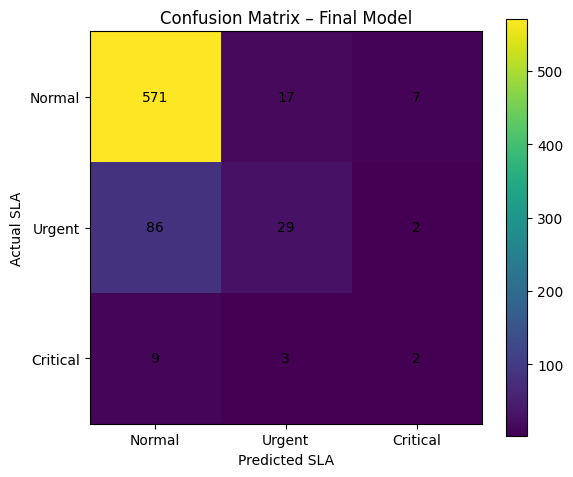

In [51]:
#CONFUSION MATRIX FOR FINAL MODEL (Gradient Boosting)

y_pred_final = y_pred_gb # Gradient Boosting is the final chosen model

labels = ["Normal", "Urgent", "Critical"]

cm = confusion_matrix(y_test, y_pred_final, labels=labels)

plt.figure(figsize=(6, 5))
plt.imshow(cm)
plt.title("Confusion Matrix – Final Model")
plt.xlabel("Predicted SLA")
plt.ylabel("Actual SLA")
plt.xticks(range(len(labels)), labels)
plt.yticks(range(len(labels)), labels)

# Annotate cells with counts
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.show()


The confusion matrix shows strong performance for Normal shipments, which represent the majority of the data.
Urgent and especially Critical shipments remain challenging due to strong class imbalance, with the model tending to under-predict higher SLA levels.
This behavior reflects a conservative recommendation strategy, prioritizing cost efficiency over minority class recall.

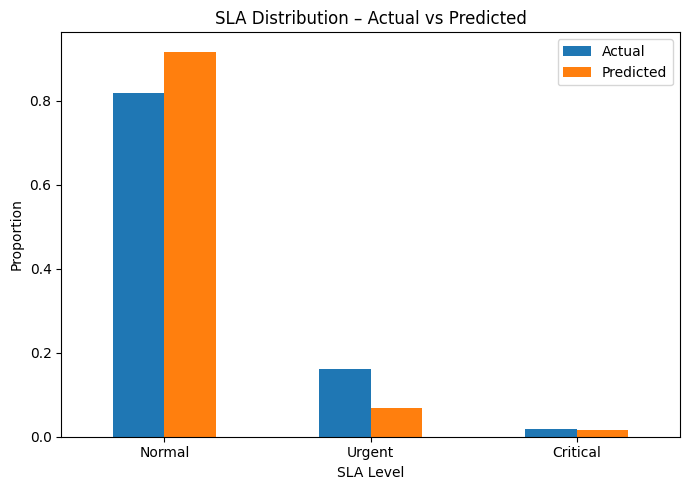

In [ ]:
#SLA distribution in actual vs predicted to check if model is capturing the overall class distribution

df_dist = pd.DataFrame({
    "Actual": pd.Series(y_test).value_counts(normalize=True),
    "Predicted": pd.Series(y_pred_final).value_counts(normalize=True)
}).fillna(0)

df_dist = df_dist.loc[["Normal", "Urgent", "Critical"]]

df_dist.plot(kind="bar", figsize=(7, 5))
plt.title("SLA Distribution – Actual vs Predicted")
plt.ylabel("Proportion")
plt.xlabel("SLA Level")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
